# Second Report: Financial Market Volatility

By: Abigail Alpert and Gabi Wurgaft

# Executive Summary
We will be predicting the short term volatility of three stocks. Through these predictions we will make recommendations to their investors and the general public whether to buy, sell, or short this stock. Our predictions will also assess whether the stock is generally stable or very volatile, which will impact decisions of whether to invest in these stocks in the short term.\
Our financial market volatility forecaster provides business value primarily to individuals. Our goal is to create a model that can inform people on whether they should or should not invest in a particular stock for short-term gain. By modelling stock volatility, investors will be more informed about the likelihood of how a specific stock will gain and lose value over a short-term timeframe. This information will (hopefully) help minimize risk.\
The data asset we are using is the AlphaVantage API. It provides 20+ years of historical global equity data in the form of intraday, daily, weekly, and monthly stock prices. We are using 1-minute intraday stock price data for Apple, NextEra Energy, and Eli Lilly. We use this data to calculate the volatility for each day and predict future volatility.

In [92]:
# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import patchworklib as pw
import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from pmdarima.arima import auto_arima
from arch import arch_model

# Data Preprocessing

We pulled five years of 1-minute returns for the Apple, NextEra Energy, and Eli Lilly stocks from the AlphaVantage API
The data pulled from the API was fairly clean to begin with so for the initial preprocessing we simply renamed columns and handled timestamps.\
We looked at the summary statistics to better understand the data, as well as plotted the open, close, high, and low prices of each stock to understand any trends. Below are those visualizations and summary statistics:

In [65]:
# Read Data
aapl_df = pd.read_csv("data_files/AAPL_combined.csv.gz")
lly_df = pd.read_csv("data_files/LLY_combined.csv.gz")
nee_df = pd.read_csv("data_files/NEE_combined.csv.gz")

# Data Preprocessing
def data_preprocess(df):
    # Rename columns
    df.rename(columns={'Unnamed: 0': 'timestamp',
                       '1. open': 'open',
                       '2. high': 'high',
                       '3. low': 'low',
                       '4. close': 'close',
                       '5. volume': 'volume'}, inplace=True)
    
    # Drop unnecessary columns
    if 'Unnamed: 0.1' in df.columns.tolist():
        df.drop(columns=['Unnamed: 0.1'], inplace=True)

    # Handle data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    return df

aapl_df = data_preprocess(aapl_df)
lly_df = data_preprocess(lly_df)
nee_df = data_preprocess(nee_df)

For the Apple summary statistics, notice that the stock price varies by about $200 over the full dataframe. Since our data is on a minute level, the values do not differ too much between the open, high, low, and close prices.

In [66]:
aapl_df.describe()

,open,high,low,close,volume
count,562931.000000,562931.000000,562931.000000,562931.000000,5.629310e+05
mean,160.515991,160.593207,160.437746,160.516211,1.647944e+05
std,45.624113,45.636280,45.611705,45.624154,2.178602e+05
min,51.539100,51.672300,51.476200,51.529400,6.000000e+00
25%,130.567100,130.630900,130.504700,130.565450,6.793800e+04
50%,160.717500,160.820600,160.624200,160.718600,1.116850e+05
75%,190.944100,191.003600,190.879900,190.944100,1.919780e+05
max,259.008600,265.706100,258.809300,259.028400,2.035834e+07


For the Eli Lilly summary statistics notice that the stock price varies by about $850 over the full dataframe. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

In [67]:
lly_df.describe()

,open,high,low,close,volume
count,558186.000000,558186.000000,558186.000000,558186.000000,5.581860e+05
mean,433.285002,433.485025,433.081830,433.283493,5.859736e+03
std,264.277398,264.407444,264.144637,264.275595,1.108389e+04
min,109.690000,109.971000,109.643100,109.821100,1.000000e+00
25%,208.908500,208.970800,208.842600,208.890500,1.717000e+03
50%,323.250800,323.396450,323.113400,323.259600,3.252000e+03
75%,733.159150,733.555975,732.695800,733.151675,6.246000e+03
max,964.839100,965.136800,963.310800,964.610700,1.246834e+06


For the NextEra Energy, notice that the stock prices varies by about $47 over the full dataframe. This is considerably less than the other stocks that we are looking at, because the share price of NEE is less than AAPL or LLY. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

In [68]:
nee_df.describe()

,open,high,low,close,volume
count,561062.000000,561062.000000,561062.000000,561062.000000,5.610620e+05
mean,67.840804,67.870138,67.811441,67.840857,1.717475e+04
std,8.209927,8.208426,8.211482,8.209971,3.573411e+04
min,38.178500,38.263500,38.141300,38.212300,1.000000e+00
25%,63.477200,63.505200,63.451275,63.478600,5.937000e+03
50%,69.150500,69.180500,69.122300,69.150500,1.013200e+04
75%,73.489500,73.515800,73.462400,73.489400,1.791600e+04
max,84.675400,85.519400,84.648300,84.675400,4.796161e+06


### Apple Plots

Although there is a general upwards trend over time, the increase in stock price is not consistent

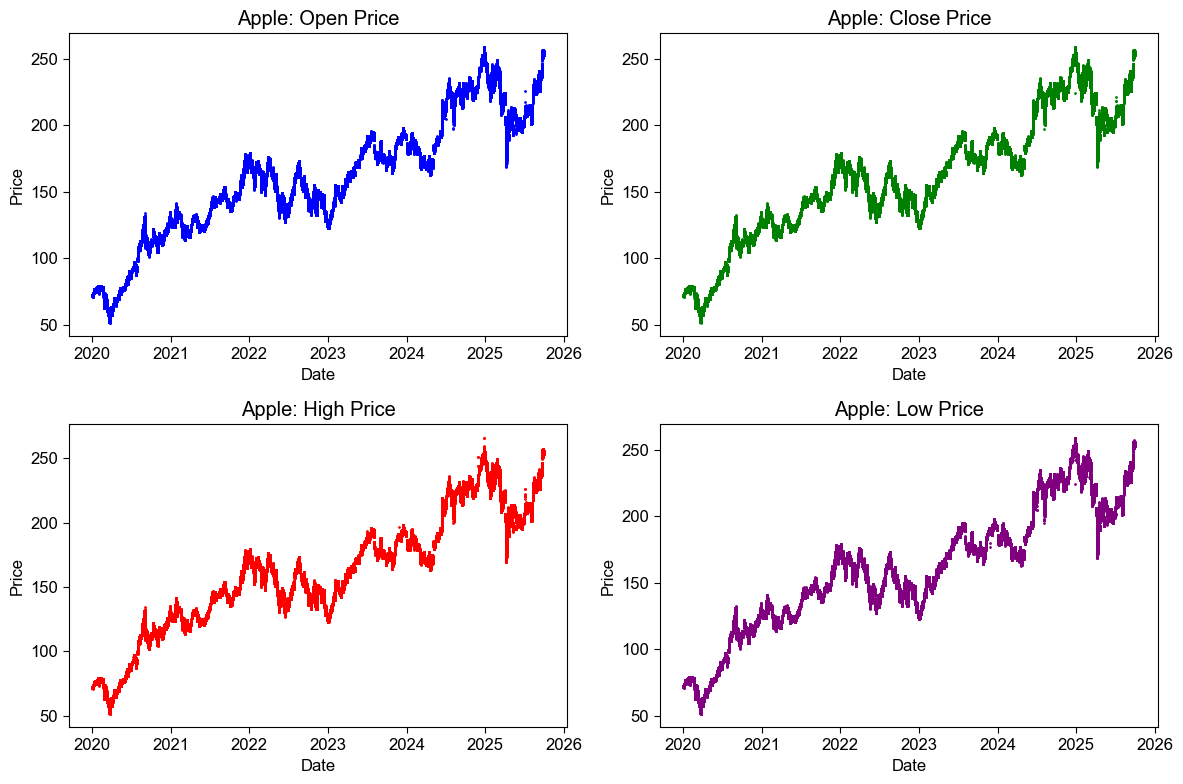

In [69]:
aapl_df['timestamp'] = pd.to_datetime(aapl_df['timestamp'])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

columns = ['open', 'close', 'high', 'low']
titles = ["Apple: Open Price", "Apple: Close Price", "Apple: High Price", "Apple: Low Price"]
colors = ['blue', 'green', 'red', 'purple']

for ax, col, title, color in zip(axs.flat, columns, titles, colors):
    ax.scatter(aapl_df['timestamp'], aapl_df[col], s=1, color=color)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

### Eli Lilly Plots

Notice that the stock price was increasing steadily until March 2023 when the price increased dramatically. Since June 2024, the LLY stock price has been on a general decreasing trend

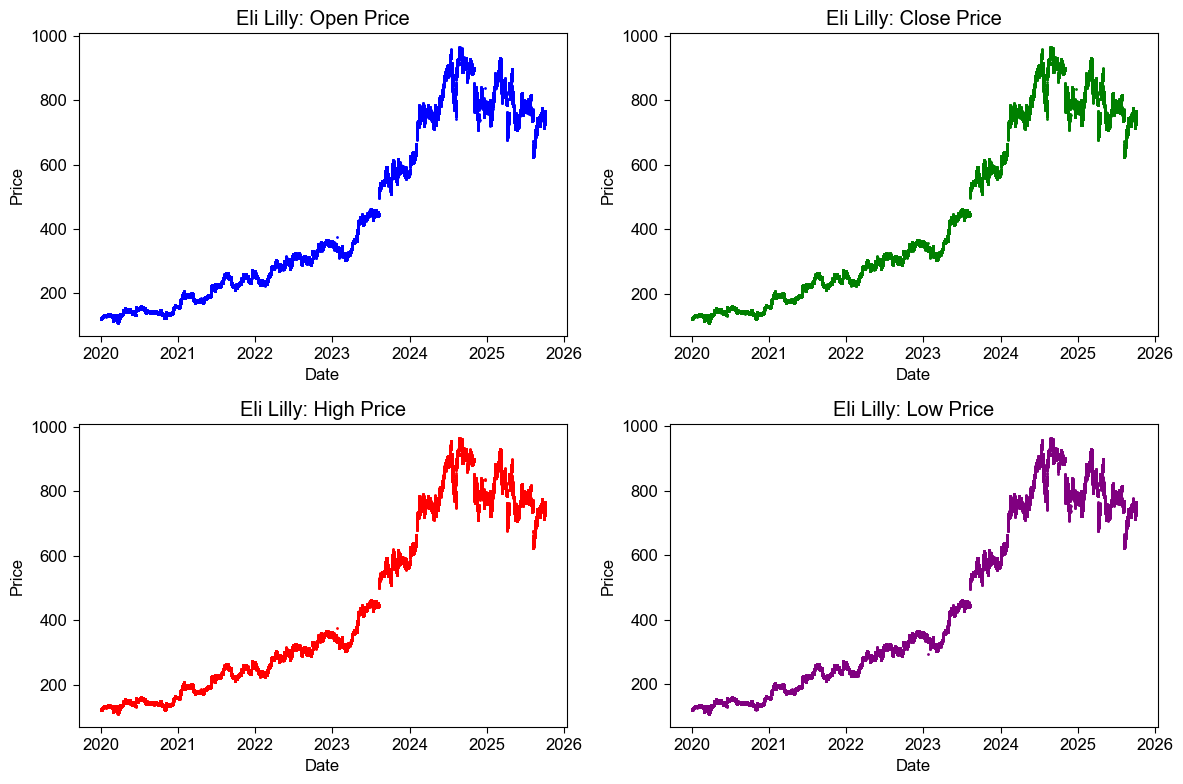

In [70]:
aapl_df['timestamp'] = pd.to_datetime(aapl_df['timestamp'])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

columns = ['open', 'close', 'high', 'low']
titles = ["Eli Lilly: Open Price", "Eli Lilly: Close Price", "Eli Lilly: High Price", "Eli Lilly: Low Price"]
colors = ['blue', 'green', 'red', 'purple']

for ax, col, title, color in zip(axs.flat, columns, titles, colors):
    ax.scatter(lly_df['timestamp'], lly_df[col], s=1, color=color)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

### NextEra Plots

Notice that the NextEra stock price shot up dramatically startin in March 2020 through the end of the year. Since then, there have been many flucations, but a general decrease in stock price. Since the start of 2025, the nee stock prices has been mostly increasing.

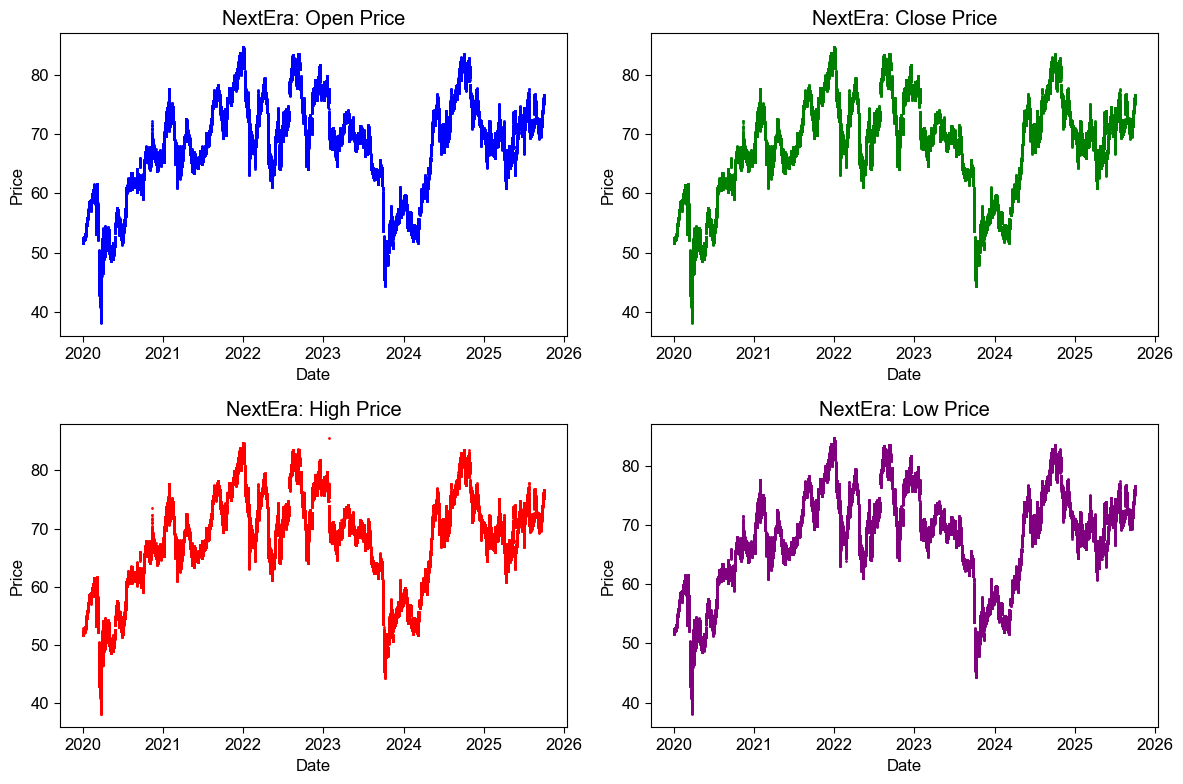

In [71]:
aapl_df['timestamp'] = pd.to_datetime(aapl_df['timestamp'])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

columns = ['open', 'close', 'high', 'low']
titles = ["NextEra: Open Price", "NextEra: Close Price", "NextEra: High Price", "NextEra: Low Price"]
colors = ['blue', 'green', 'red', 'purple']

for ax, col, title, color in zip(axs.flat, columns, titles, colors):
    ax.scatter(nee_df['timestamp'], nee_df[col], s=1, color=color)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

We then calculated the log returns for each minute using the formula log_returns = log(1+(close-open)/open).

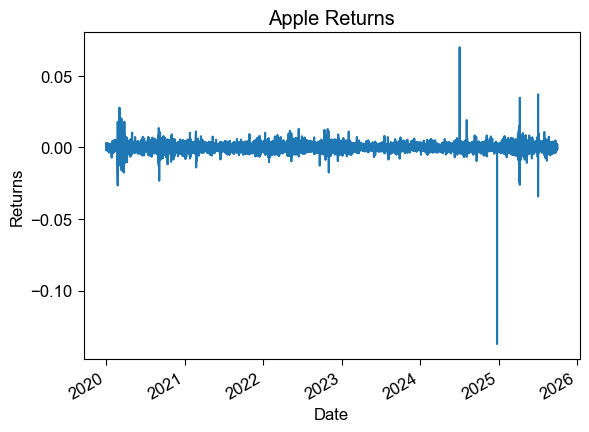

In [72]:
#Load in AAPL data, make returns, variance, and volatility
AAPL_returns = pd.DataFrame({
    "time_stamp": aapl_df['timestamp'],
    "log_return": np.log(1+(aapl_df['close']-aapl_df['open'])/aapl_df['open'])
})
AAPL_returns['time_stamp'] = pd.to_datetime(AAPL_returns['time_stamp'], errors='coerce')
daily_variance_AAPL = AAPL_returns.groupby(AAPL_returns['time_stamp'].dt.floor("1D"))["log_return"].var()
#Plot returns
AAPL_returns.set_index("time_stamp", inplace=True)
AAPL_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Apple Returns")
plt.show()

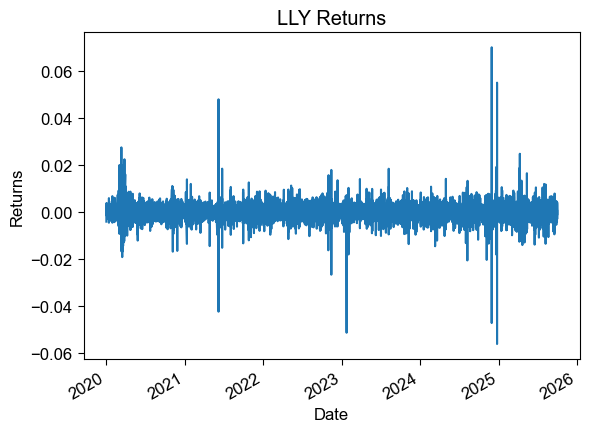

In [73]:
LLY_returns = pd.DataFrame({
    "time_stamp": lly_df["timestamp"],
    "log_return": np.log(1+(lly_df['close']-lly_df['open'])/lly_df['open'])
})
LLY_returns['time_stamp'] = pd.to_datetime(LLY_returns['time_stamp'], errors='coerce')
daily_variance_LLY = LLY_returns.groupby(LLY_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

LLY_returns.set_index("time_stamp", inplace=True)
LLY_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("LLY Returns")
plt.show()

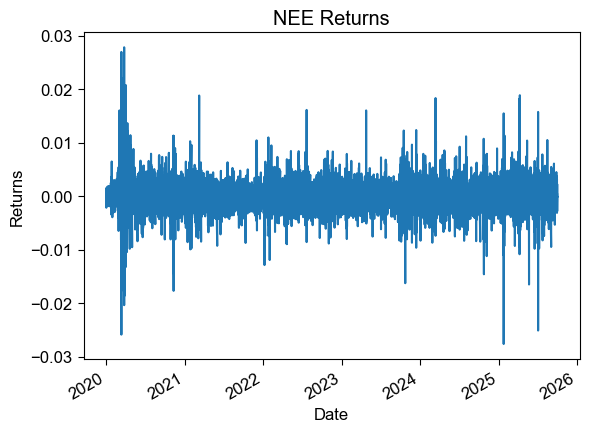

In [74]:
NEE_returns = pd.DataFrame({
    "time_stamp": nee_df["timestamp"],
    "log_return": np.log(1+(nee_df['close']-nee_df['open'])/nee_df['open'])
})
NEE_returns['time_stamp'] = pd.to_datetime(NEE_returns['time_stamp'], errors='coerce')
daily_variance_NEE = NEE_returns.groupby(NEE_returns['time_stamp'].dt.floor("1D"))["log_return"].var()
NEE_returns.set_index("time_stamp", inplace=True)
NEE_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("NEE Returns")
plt.show()

From the log return values, we calculated the daily variance of the returns for each of the stocks and took the square root of the variance to calculate the realized volatility for each stock.\
It was important to derive the daily volatility for each stock because we are trying to predict the volatility for the next day. The data needed to be in the form of daily volatility in order to be interpreted and parsed by the different algorithms.

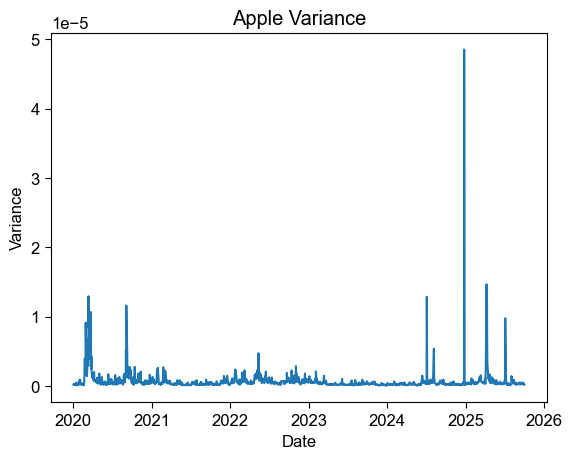

In [75]:
#Plot variance
plt.plot(daily_variance_AAPL.index, daily_variance_AAPL.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("Apple Variance")
plt.show()

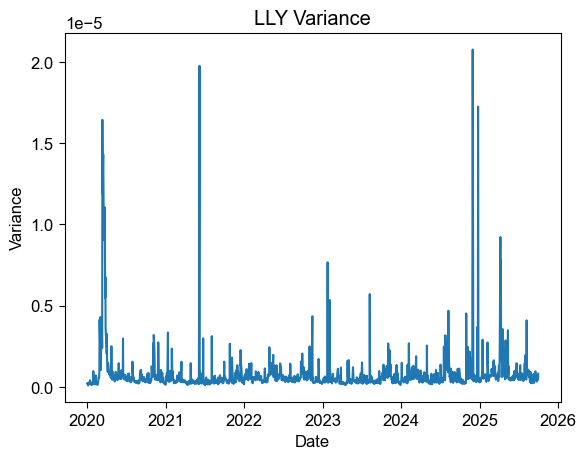

In [76]:
plt.plot(daily_variance_LLY.index, daily_variance_LLY.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("LLY Variance")
plt.show()

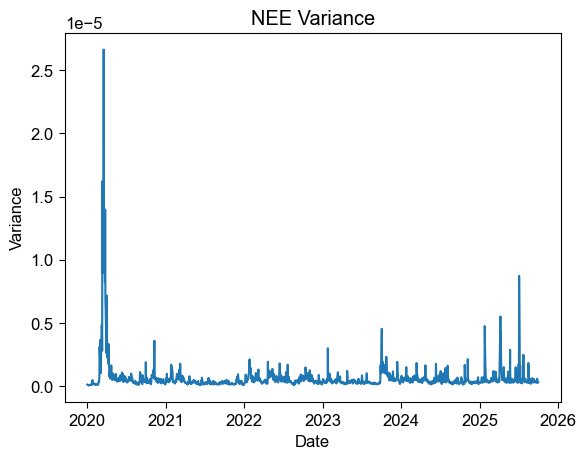

In [77]:
plt.plot(daily_variance_NEE.index, daily_variance_NEE.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("NEE Variance")
plt.show()

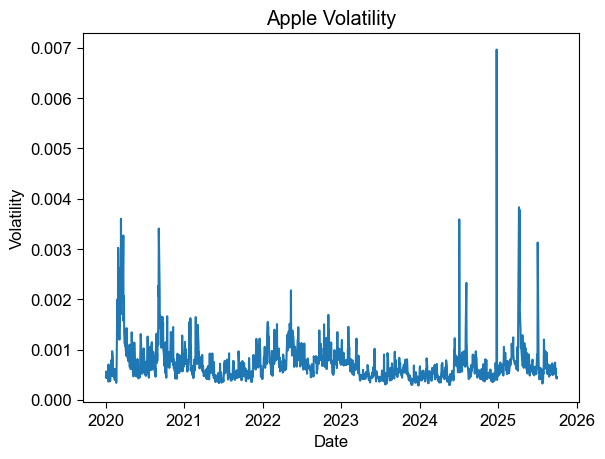

In [78]:
#Plot volatility
daily_volatility_AAPL = np.sqrt(daily_variance_AAPL)
df = pd.DataFrame(daily_volatility_AAPL)
df = df.rename(columns={'log_return': 'volatility'})

plt.plot(daily_volatility_AAPL.index, daily_volatility_AAPL.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Apple Volatility")
plt.show()

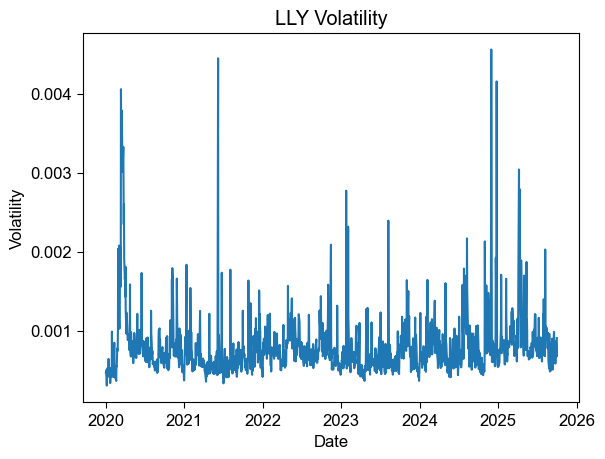

In [79]:
daily_volatility_LLY = np.sqrt(daily_variance_LLY)
plt.plot(daily_volatility_LLY.index, daily_volatility_LLY.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("LLY Volatility")
plt.show()

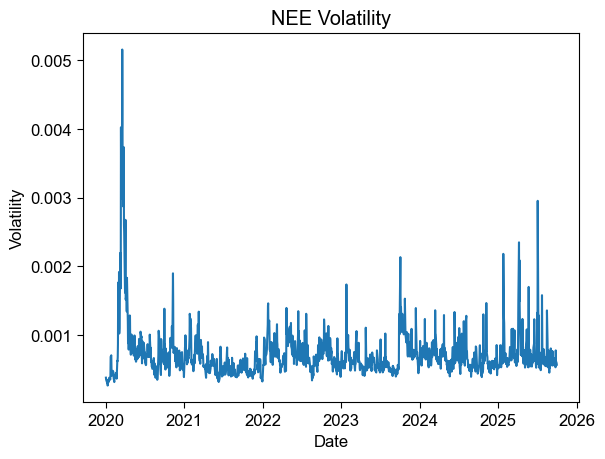

In [80]:
daily_volatility_NEE = np.sqrt(daily_variance_NEE)
plt.plot(daily_volatility_NEE.index, daily_volatility_NEE.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("NEE Volatility")
plt.show()

We also looked at the autocorrelation of the daily volatility for the different stocks to see if it is possible to predict future volatility based on historical data. We found that the current volatility shows a clear dependence on values from roughly two weeks prior. This gave us evidence that we can use historical data to predict future volatility.

### Apple Autocorrelation

1 0.5769805692458504
2 0.5453167336440364
3 0.48211137176396585
4 0.4274409025756956
5 0.38646529094706256


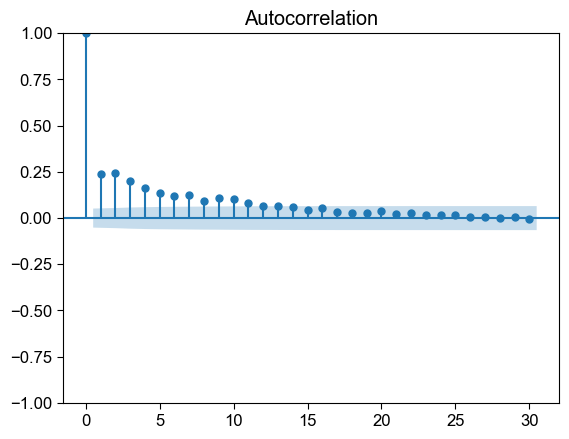

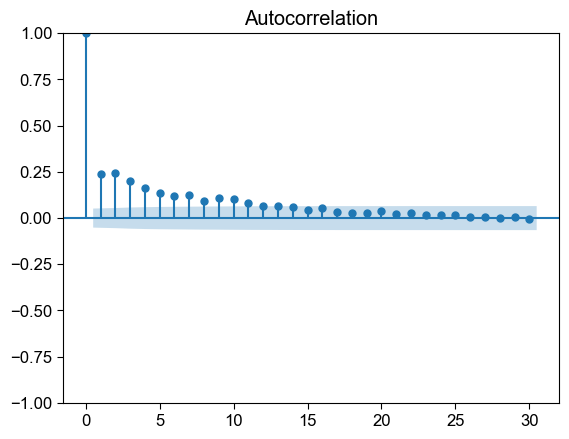

In [81]:
from statsmodels.graphics.tsaplots import plot_acf

for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_AAPL).autocorr(lag=lag))

plot_acf(daily_variance_AAPL, lags=30)

### NextEra Autocorreltation

1 0.8017619086726411
2 0.7593705377598482
3 0.6936931727594111
4 0.6529020403137563
5 0.6014995267200856


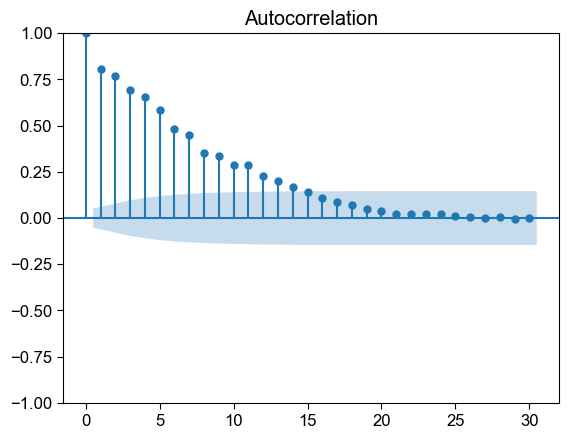

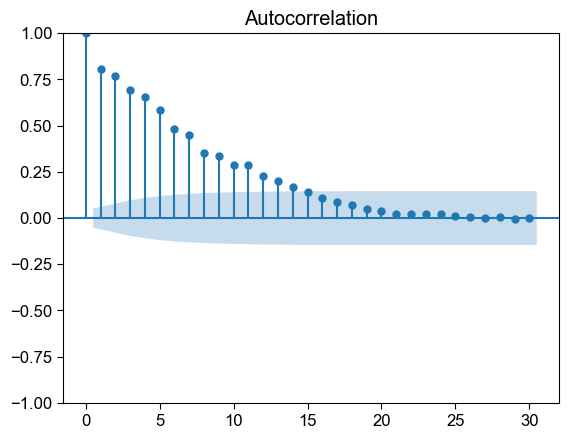

In [82]:
for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_NEE).autocorr(lag=lag))

plot_acf(daily_variance_NEE, lags=30)

### Eli Lilly Autocorrelation

1 0.5470570909894628
2 0.48744389860830045
3 0.42143469439362613
4 0.3980873030426876
5 0.3651799362045467


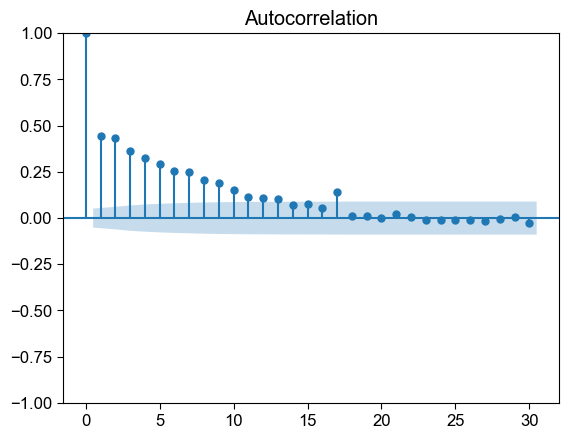

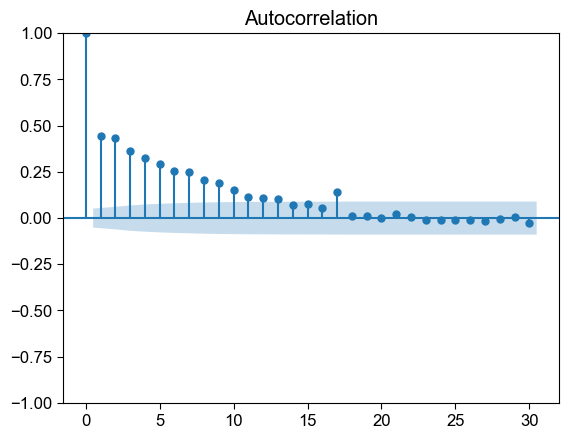

In [83]:
for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_LLY).autocorr(lag=lag))


plot_acf(daily_variance_LLY, lags=30)

To detect outliers, we used the Seasonal Trend Decomposition using LOESS technique that removes the trend and seasonal components from the data so you are left with the residual component. The method to perform this technique is from the python library from statsmodels.tsa.seasonal import STL. Once we had the residual component for each stock, we found the Q1 and Q3 values of the data, the IQR, and filtered the data so that no datapoint is greater than Q3+1.5*IQR or less than Q1+1.5*IRQ.\
However, we are not certain we want to remove the outliers from the data because we believe that outliers are indicators of volatility. We believe that we can predict some of what the STL method considers to be outliers through a more robust model that includes supplemental information.

### Apple Seasonal Trend Decomp.

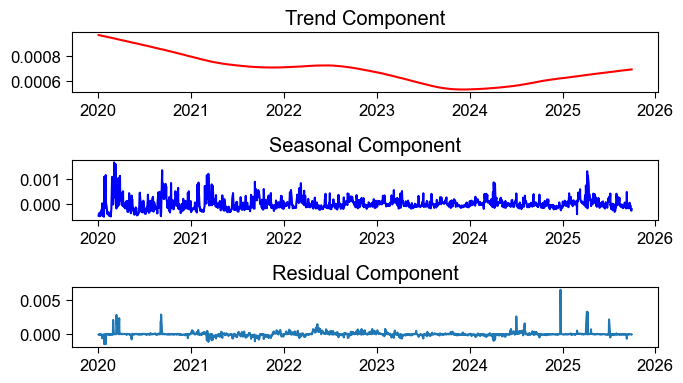

In [84]:
from statsmodels.tsa.seasonal import STL

stl_AAPL = STL(daily_volatility_AAPL.values, period=252, robust=True)
result_AAPL = stl_AAPL.fit()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 4))

#from https://www.geeksforgeeks.org/data-analysis/seasonal-decomposition-of-time-series-by-loess-stl/
ax1.plot(daily_volatility_AAPL.index, result_AAPL.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(daily_volatility_AAPL.index, result_AAPL.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(daily_volatility_AAPL.index, result_AAPL.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

### NextEra Seasonal Trend Decomp.

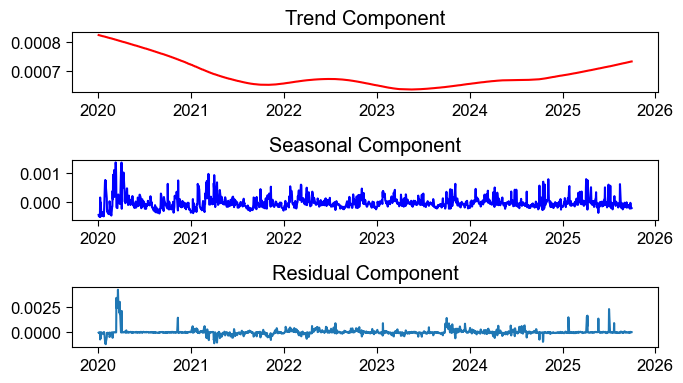

In [85]:
stl_BEP = STL(daily_volatility_NEE.values, period=252, robust=True)
result_BEP = stl_BEP.fit()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 4))

#from https://www.geeksforgeeks.org/data-analysis/seasonal-decomposition-of-time-series-by-loess-stl/
ax1.plot(daily_volatility_NEE.index, result_BEP.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(daily_volatility_NEE.index, result_BEP.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(daily_volatility_NEE.index, result_BEP.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

### Eli Lilly Seaonsonal Trend Decomp.

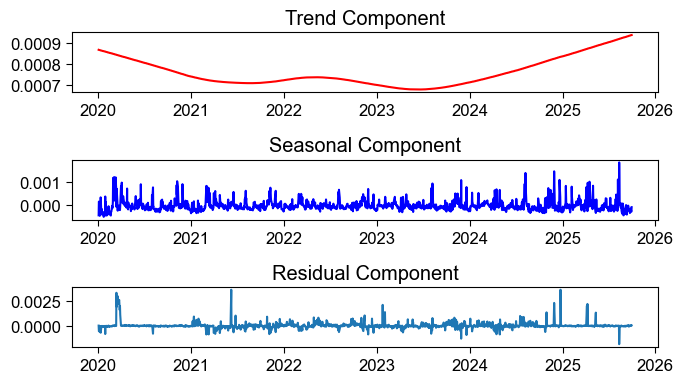

In [86]:
stl_LLY = STL(daily_volatility_LLY.values, period=252, robust=True)
result_LLY = stl_LLY.fit()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 4))

#from https://www.geeksforgeeks.org/data-analysis/seasonal-decomposition-of-time-series-by-loess-stl/
ax1.plot(daily_volatility_LLY.index, result_LLY.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(daily_volatility_LLY.index, result_LLY.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(daily_volatility_LLY.index, result_LLY.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

# Model Updates

We are using four types of models – Exponentially Weighted Moving Average (EWMA), Autoregressive Integrated Moving Average (ARIMA), Generalized Auto-Regressive Conditional Heteroskedasticity (GARCH) and Long Short-Term Memory (LSTM) – to forecast short-term volatility of our selected stocks. We are treating EWMA and ARIMA as our baseline models, since they are both standard statistical models that are easy to interpret. Meanwhile, we hope that our LSTM will form a more robust prediction, despite suffering from the “black-box” phenomenom.

In [94]:
# Data prep
aapl = pd.read_csv("data_files/AAPL_combined.csv.gz")
nee = pd.read_csv("data_files/NEE_combined.csv.gz")
lly = pd.read_csv("data_files/LLY_combined.csv.gz")


def data_preprocess(df):
    # Rename columns
    df.rename(columns={'Unnamed: 0': 'timestamp',
                       '1. open': 'open',
                       '2. high': 'high',
                       '3. low': 'low',
                       '4. close': 'close',
                       '5. volume': 'volume'}, inplace=True)
    
    # Drop unnecessary columns
    if 'Unnamed: 0.1' in df.columns.tolist():
        df.drop(columns=['Unnamed: 0.1'], inplace=True)

    # Handle data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    return df

aapl = data_preprocess(aapl)
nee = data_preprocess(nee)
lly = data_preprocess(lly)

def daily_volatility(df):
    """
    Aggregates to daily level and calculates volatility based on the 
    logic: sqrt(log(1 + (close - open) / open))
    """
    # Select columns and drop NAs
    df = df[['timestamp', 'open', 'close']].dropna().copy()
    
    # Convert timestamp to datetime and extract the date
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    
    # Group by date to get first open and last close
    daily = df.groupby('date').agg(
        open=('open', 'first'),
        close=('close', 'last')
    ).reset_index()
    
    # Calculate log return
    # equivalent to R: log(1 + (close - open) / open) -> log(close / open)
    daily['log_return'] = np.log(1 + (daily['close'] - daily['open']) / daily['open'])
    
    # Calculate volatility
    # Note: If log_return is negative, sqrt will result in NaN. 
    # We use np.sqrt where valid, otherwise NaN.
    daily['volatility'] = daily['log_return'].apply(lambda x: np.sqrt(x) if x > 0 else np.nan)
    
    # Return only date and volatility, dropping any rows where calculation failed (NaNs)
    return daily[['date', 'volatility']].dropna()

aapl_vol = daily_volatility(aapl)
nee_vol = daily_volatility(nee)
lly_vol = daily_volatility(lly)

### EWMA

Exponentially weighted moving average is a classic model used for time series forecasting. The model gives more weight to the more recent data than older data. This is the initial baseline model since it is very simple. EWMA is a variant of a Moving Average model that weighs observations based on their temporal proximity to the prediction time. EWMA models are often used for financial market volatility prediction because heavier weights on more recent observations allow the model to react more quickly to clusters and spikes in the data than a standard Moving Average model can react.

The EWMA model has one parameter called lambda (also called alpha sometimes), which is the decay rate, thus influencing how the weights of historic data are calculated. Originally, after a quick visual check, we thought that an EWMA model with a decay factor of 0.9 best fit our data, as can be seen in the graphs below. Next, we completed a more thorough and data-driven check using a variant of 5-fold cross-validation with time-aware splits. Using RMSE as our metric, we found that the optimal lambda parameter values are as follows:

| Ticker | Lambda |
|--------|---------|
| AAPL   | 0.05    |
| NEE    | 0.01    |
| LLY    | 0.01    |

We evaluated the performance of the model with our testing data looking at RMSE, AIC, and BIC.


In [89]:
# AAPL EWMA -- Prelim

In [90]:
# LLY EWMA -- Prelim

In [91]:
# NEE EWMA -- Prelim

In [93]:
# Robust EWMA implementation
class EWMAResults:

    def __init__(self, data, lambda_val):
        self._data = data
        self._lambda = lambda_val
    
        self.conditional_volatility = data.ewm(alpha=lambda_val, adjust=False).mean()
        self.resid = data - self.conditional_volatility

    def summary(self):
        print("EWMA Model Results")
        print("==================")
        print(f"Lambda (alpha): {self._lambda}")
        print(f"Last Volatility: {self.conditional_volatility.iloc[-1]:.5f}")
        return ""

    def forecast(self, horizon=1):
        last_vol = self.conditional_volatility.iloc[-1]

        class ForecastObj:
            def __init__(self, val, h):
                self.volatility = pd.Series([val] * h, name='h.1')
                self.variance = self.volatility ** 2
        
        return ForecastObj(last_vol, horizon)
    
def fit_ewma(df, lambda_):

    series = df['volatility'] 
    
    results = EWMAResults(series, lambda_)
    
    return results

def find_best_lambda_cv(vol_series, n_splits=5):

    lambdas = np.linspace(0.01, 0.99, 50)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    avg_rmse_scores = []
    
    print(f"--- Hyper-tuning Lambda with {n_splits}-Fold CV ---")
    
    for lam in lambdas:
        fold_rmses = []
        
        for train_index, test_index in tscv.split(vol_series):
            # Split data
            train = vol_series.iloc[train_index]
            test = vol_series.iloc[test_index]

            train_ewma = train.ewm(alpha=lam, adjust=False).mean()
            last_train_vol = train_ewma.iloc[-1]
            
            full_chunk = vol_series.iloc[np.concatenate([train_index, test_index])]
            full_ewma = full_chunk.ewm(alpha=lam, adjust=False).mean()
            
            predictions = full_ewma.shift(1).iloc[test_index]
            
            actuals = test
            
            valid = ~np.isnan(predictions)
            rmse = np.sqrt(mean_squared_error(actuals[valid], predictions[valid]))
            fold_rmses.append(rmse)
        
        avg_rmse_scores.append(np.mean(fold_rmses))

    best_idx = np.argmin(avg_rmse_scores)
    best_lambda = lambdas[best_idx]
    best_score = avg_rmse_scores[best_idx]
    
    return best_lambda

In [95]:
best_lam = find_best_lambda_cv(aapl_vol['volatility'], n_splits=5)
print(f"Optimal Lambda found aapl: {best_lam:.3f}")
best_lam = find_best_lambda_cv(nee_vol['volatility'], n_splits=5)
print(f"Optimal Lambda found nee: {best_lam:.3f}")
best_lam = find_best_lambda_cv(lly_vol['volatility'], n_splits=5)
print(f"Optimal Lambda found lly: {best_lam:.3f}")

--- Hyper-tuning Lambda with 5-Fold CV ---
Optimal Lambda found aapl: 0.050
--- Hyper-tuning Lambda with 5-Fold CV ---
Optimal Lambda found nee: 0.010
--- Hyper-tuning Lambda with 5-Fold CV ---
Optimal Lambda found lly: 0.010


In [96]:
aapl_ewma = fit_ewma(aapl_vol, lambda_ = 0.05)
nee_ewma = fit_ewma(nee_vol, lambda_= 0.01)
lly_ewma = fit_ewma(lly_vol, lambda_ = 0.01)

### ARIMA

ARIMA is a variant of an Autoregressive Moving Average (ARMA) model that allows for analysis and predictions for non-stationary data. The integration (differencing) removes the underlying trends in the data, allowing for the data to be “assumed” as stationary data. Meanwhile, the Autoregressive part of the model captures the dependence on past observation values. The Moving Average portion of the model addresses the past forecast errors, or how much the model depends on past shocks. Like EWMA, ARIMA models are also commonly used for volatility forecasting since volatility series typically exhibit autocorrelation and mean reversion.

ARIMA models typically have three parameters – p, d, and q. The parameter p is the order of the auto-regressive component of the model. The parameter d is the degree of differencing needed to make the data stationary. The parameter q is the order of the moving average component of the model. Traditionally, parameters would need to be tuned using methods like k-fold cross-validation. Since standard K-fold cross-validation does not work for time series data, we used a model that self-optimizes the parameters. We used one of these models, auto_arima from “pmdarima” called “auto_arima.” The parameters are tuned by performing a smart version of grid search over different parameter values. First, the model finds the correct d value, the differencing degree that makes the data stationary, using stationarity tests. Then, with d fixed, the program performs a stepwise search using AIC for evaluation to find the optimal p and q values. This parameter tuning method is fast and statistically sound.

The optimal parameters are as follows:

| Ticker | p | d | q |
|--------|---|---|---|
| AAPL   | 0 | 1 | 1 |
| NEE    | 1 | 0 | 1 |
| LLY    | 1 | 0 | 1 |

We evaluated the performance of the model with our testing data looking at RMSE, AIC, and BIC.


--- Auto ARIMA for AAPL ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  775
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1305.051
Date:                Fri, 12 Dec 2025   AIC                          -2606.102
Time:                        12:34:48   BIC                          -2596.799
Sample:                             0   HQIC                         -2602.523
                                - 775                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9425      0.011    -82.846      0.000      -0.965      -0.920
sigma2         0.0020   7.28e-05     27.529      0.000       0.002       0.002
Ljung-Box (L1) (Q):     

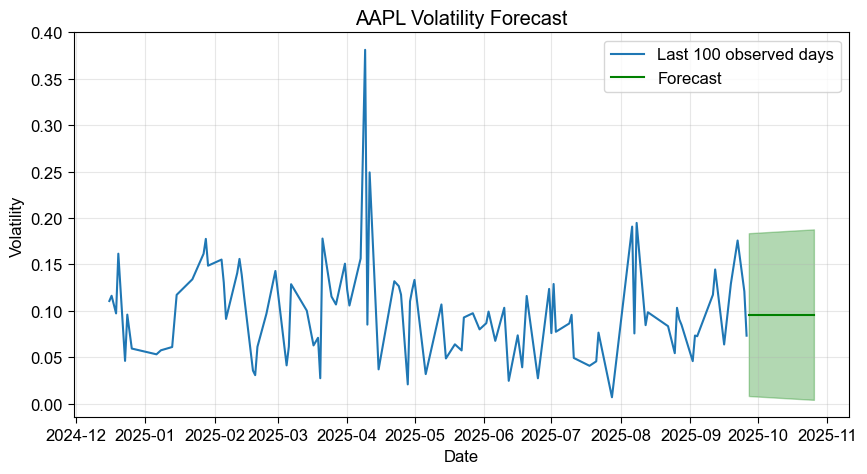

--- Auto ARIMA for NEE ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  746
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1266.845
Date:                Fri, 12 Dec 2025   AIC                          -2525.691
Time:                        12:34:51   BIC                          -2507.232
Sample:                             0   HQIC                         -2518.576
                                - 746                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0099      0.005      1.890      0.059      -0.000       0.020
ar.L1          0.8948      0.055     16.174      0.000       0.786       1.003
ma.L1         -0.8233    

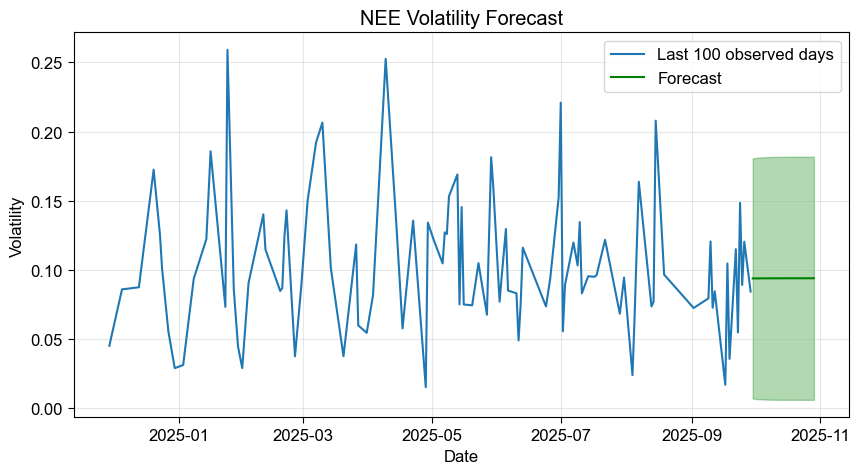

--- Auto ARIMA for LLY ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  756
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1246.578
Date:                Fri, 12 Dec 2025   AIC                          -2485.156
Time:                        12:34:55   BIC                          -2466.644
Sample:                             0   HQIC                         -2478.025
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0129      0.007      1.928      0.054      -0.000       0.026
ar.L1          0.8676      0.068     12.697      0.000       0.734       1.002
ma.L1         -0.7805    

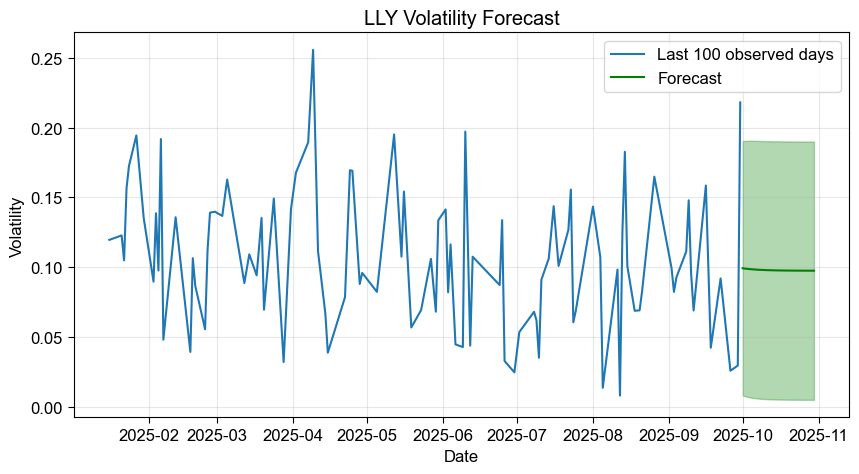

In [97]:
def fit_and_plot_arima(df, name):
    print(f"--- Auto ARIMA for {name} ---")

    # Make data a series
    series = df['volatility'].values
    
    # Model
    model = auto_arima(series, seasonal=False, error_action='ignore', suppress_warnings=True)
    print(model.summary())
    
    # Forecast
    n_periods = 30
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    last_date = df['date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=x) for x in range(1, n_periods + 1)]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'][-100:], series[-100:], label='Last 100 observed days') # historic
    plt.plot(forecast_dates, forecast, label='Forecast', color='green') # forecast
    plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.3)
    plt.title(f"{name} Volatility Forecast")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


fit_and_plot_arima(aapl_vol, "AAPL")
fit_and_plot_arima(nee_vol, "NEE")
fit_and_plot_arima(lly_vol, "LLY")

In [98]:
def fit_arima(df):

    series = df['volatility'].values

    model = auto_arima(series, seasonal=False, error_action='ignore', suppress_warnings=True)

    return model

aapl_arima = fit_arima(aapl_vol)
nee_arima = fit_arima(nee_vol)
lly_arima = fit_arima(lly_vol)

### GARCH

A GARCH model is an extension of the ARCH framework that allows for modeling and forecasting time-varying volatility in a series. Instead of assuming constant variance, GARCH explicitly models the conditional variance as a function of past shocks and past variances. The auto-regressive part of the model captures how past volatility persists into the present, while the moving-average component reflects how new information, like large shocks, immediately increases volatility. Similar to our other baseline models, GARCH is commonly used for financial market volatility prediction because GARCH models can address volatility clustering, mean reversion, and periods of large and small fluctuations. The standard parameters are GARCH(1, 1).

GARCH models have two parameters – p and q. The p parameter is the GARCH order, which represents the lagged conditional variances and captures the volatility present. Larger p values mean that volatility decays more slowly. The q parameter is the ARCH orde,r which represents the lagged squared variances and captures the information in the shocks. Larger q values mean that the model reacts more strongly to recent shocks. Once again, traditional k-fold CV does not work for parameter tuning because we are using time series data. Instead, we use a combination of grid search and cross-validation that allows us to preserve the time relationships within the data while comparing model performance under different parameters. During this tuning, we use MSE for model comparison since MSE generalizes well.

The optimal parameters are as follows:

| Ticker | p | q |
|--------|---|---|
| AAPL   | 1 | 1 |
| NEE    | 2 | 3 |
| LLY    | 3 | 3 |

We evaluated the performance of the model with our testing data looking at RMSE, AIC, and BIC.


In [99]:
def optimize_garch_cv(returns_series, n_splits=5):
    """
    Finds best p, q using Time Series Cross-Validation.
    Metric: MSE of (Predicted Variance - Actual Squared Returns).
    """
    
    # Grid
    p_range = [1, 2, 3]
    q_range = [1, 2, 3]
    
    # TS data split
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    results = []

    print(f"{'p':<4} {'q':<4} {'Avg MSE':<15}")
    print("-" * 30)

    # Grid search
    for p in p_range:
        for q in q_range:
            mse_scores = []
            
            # CV "Folds"
            for train_idx, test_idx in tscv.split(returns_series):
                # Split data
                train_data = returns_series.iloc[train_idx]
                test_data = returns_series.iloc[test_idx]
                
                # Fit Model
                try:
                    model = arch_model(train_data, vol='Garch', p=p, q=q, mean='Zero')
                    res = model.fit(disp='off')
           
                    forecasts = res.forecast(horizon=len(test_data), reindex=False)
                    
                    pred_variance = forecasts.variance.values[-1]
                    
                    actual_variance_proxy = test_data ** 2
                    
                    mse = mean_squared_error(actual_variance_proxy, pred_variance)
                    mse_scores.append(mse)
                    
                except:
                    continue
            
            # Average score across all folds
            if mse_scores:
                avg_mse = np.mean(mse_scores)
                results.append({'p': p, 'q': q, 'score': avg_mse})
                print(f"{p:<4} {q:<4} {avg_mse:.4f}")

    results_df = pd.DataFrame(results)
    best_params = results_df.loc[results_df['score'].idxmin()]
    
    print("-" * 30)
    print(f"BEST PARAMS via CV: p={int(best_params.p)}, q={int(best_params.q)}")
    return int(best_params.p), int(best_params.q)

In [100]:
print("------ GARCH for AAPL -------")
best_p, best_q = optimize_garch_cv(aapl_vol['volatility'])
aapl_garch = arch_model(aapl_vol['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
aapl_res = aapl_garch.fit(disp='off')
print(aapl_res.summary())

------ GARCH for AAPL -------
p    q    Avg MSE        
------------------------------
1    1    0.0001
1    2    0.0001
1    3    0.0001
2    1    0.0001
2    2    0.0001
2    3    0.0001
3    1    0.0001
3    2    0.0001
3    3    0.0001
------------------------------
BEST PARAMS via CV: p=1, q=1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                633.042
Distribution:                  Normal   AIC:                          -1260.08
Method:            Maximum Likelihood   BIC:                          -1246.13
                                        No. Observations:                  775
Date:                Fri, Dec 12 2025   Df Residuals:                      775
Time:                        12:45:30   Df Model:                   

In [102]:
print("------ GARCH for LLY -------")
best_p, best_q = optimize_garch_cv(lly_vol['volatility'])
lly_garch = arch_model(lly_vol['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
lly_res = lly_garch.fit(disp='off')
print(lly_res.summary())

------ GARCH for LLY -------
p    q    Avg MSE        
------------------------------
1    1    0.0001
1    2    0.0001
1    3    0.0001
2    1    0.0001
2    2    0.0001
2    3    0.0001
3    1    0.0001
3    2    0.0001
3    3    0.0001
------------------------------
BEST PARAMS via CV: p=3, q=3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                609.995
Distribution:                  Normal   AIC:                          -1205.99
Method:            Maximum Likelihood   BIC:                          -1173.59
                                        No. Observations:                  756
Date:                Fri, Dec 12 2025   Df Residuals:                      756
Time:                        12:45:57   Df Model:                    

In [101]:
print("------ GARCH for NEE -------")
best_p, best_q = optimize_garch_cv(nee_vol['volatility'])
nee_garch = arch_model(nee_vol['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
nee_res = nee_garch.fit(disp='off')
print(nee_res.summary())

------ GARCH for NEE -------
p    q    Avg MSE        
------------------------------
1    1    0.0001
1    2    0.0001
1    3    0.0001
2    1    0.0001
2    2    0.0001
2    3    0.0001
3    1    0.0001
3    2    0.0001
3    3    0.0001
------------------------------
BEST PARAMS via CV: p=2, q=3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                636.643
Distribution:                  Normal   AIC:                          -1261.29
Method:            Maximum Likelihood   BIC:                          -1233.60
                                        No. Observations:                  746
Date:                Fri, Dec 12 2025   Df Residuals:                      746
Time:                        12:45:44   Df Model:                    


--- Fitting GARCH(1, 1) for AAPL ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                633.042
Distribution:                  Normal   AIC:                          -1260.08
Method:            Maximum Likelihood   BIC:                          -1246.13
                                        No. Observations:                  775
Date:                Fri, Dec 12 2025   Df Residuals:                      775
Time:                        12:47:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.4402

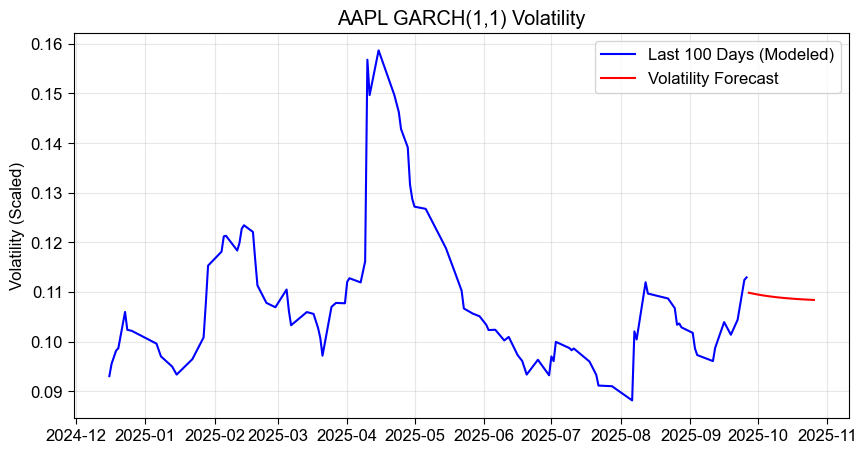


--- Fitting GARCH(2, 3) for NEE ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                636.643
Distribution:                  Normal   AIC:                          -1261.29
Method:            Maximum Likelihood   BIC:                          -1233.60
                                        No. Observations:                  746
Date:                Fri, Dec 12 2025   Df Residuals:                      746
Time:                        12:47:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.0950e

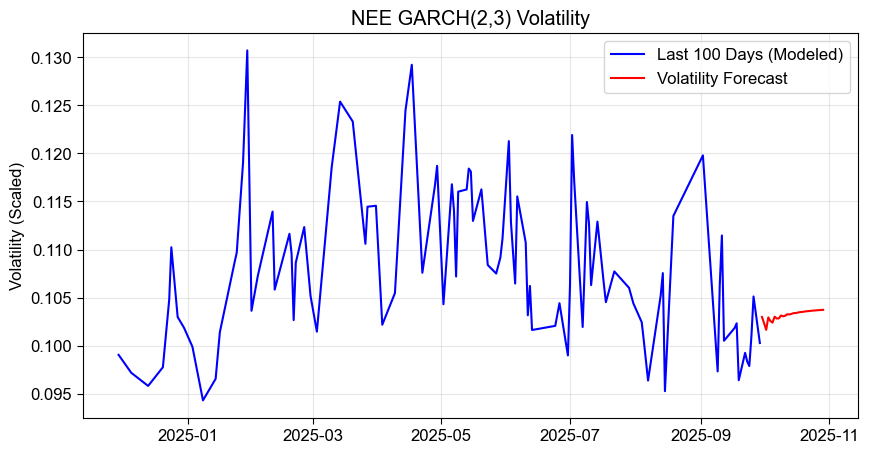


--- Fitting GARCH(3, 3) for LLY ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                609.995
Distribution:                  Normal   AIC:                          -1205.99
Method:            Maximum Likelihood   BIC:                          -1173.59
                                        No. Observations:                  756
Date:                Fri, Dec 12 2025   Df Residuals:                      756
Time:                        12:47:16   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.1117e

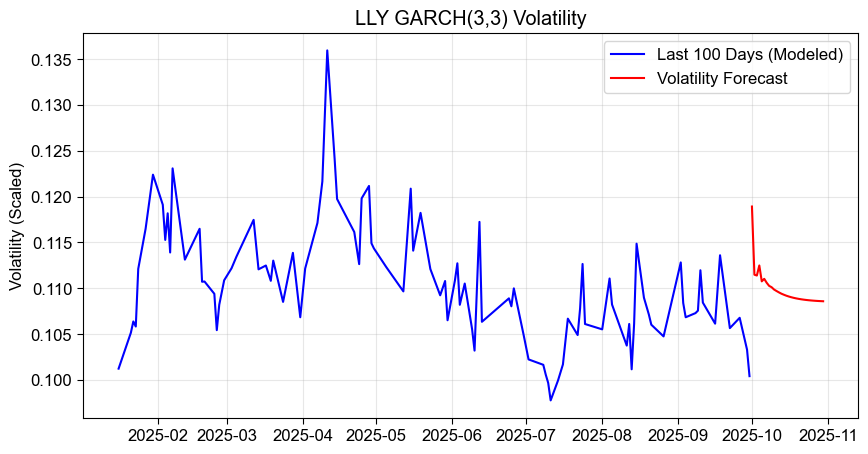

In [103]:
def fit_and_forecast_garch_pq(df, ticker_name, p, q):
    print(f"\n--- Fitting GARCH({p}, {q}) for {ticker_name} ---")
    
    # Model
    model = arch_model(df['volatility'], vol='Garch', p=p, q=q, mean='Zero')
    results = model.fit(disp='off')
    print(results.summary())
    
    # Forecast
    forecast_horizon = 30
    forecasts = results.forecast(horizon=forecast_horizon)
    pred_variance = forecasts.variance.values[-1, :]
    pred_volatility = np.sqrt(pred_variance)
    last_date = df['date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=x) for x in range(1, forecast_horizon + 1)]
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'][-100:], results.conditional_volatility[-100:], label='Last 100 Days (Modeled)', color='blue') #historic
    plt.plot(forecast_dates, pred_volatility, label='Volatility Forecast', color='red') #forecast
    plt.title(f"{ticker_name} GARCH({p},{q}) Volatility")
    plt.ylabel("Volatility (Scaled)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 4. Run the Models ---
fit_and_forecast_garch_pq(aapl_vol, "AAPL", 1, 1)
fit_and_forecast_garch_pq(nee_vol, "NEE", 2, 3)
fit_and_forecast_garch_pq(lly_vol, "LLY", 3, 3)

In [104]:
def fit_garch_pq(df, p, q):    
    # Model
    model = arch_model(df['volatility'], vol='Garch', p=p, q=q, mean='Zero')
    results = model.fit(disp='off')

    return results

aapl_garch = fit_garch_pq(aapl_vol, 1, 1)
nee_garch = fit_garch_pq(nee_vol, 2, 3)
lly_garch = fit_garch_pq(lly_vol, 3, 3)

### LSTM

Our data and modelling workflow can be thought of as a Machine Learning Morphism, a mapping from the raw market data to the volatility forecasts using data processing and modelling to learn a prediction function. The first phase of our MLM pipeline was downloading and cleaning our data, as described in the previous step. The processed data forms the input for our morphism. The next phase of our MLM is model training which has three contributing sub-components, each corresponding to a modelling technique. The EWMA sub-component captures the deterministic relationships in the data. The ARIMA sub-component adds mean-related dynamics and lag correlation to the mapping. Finally, the RNN sub-component contributes historic, temporal context to our learning problem. Our MLM is constrained by the necessity of meaningful prediction values. Our predictions need to be stable and financially valid. For example, a negative stock price and, thus, a negative volatility forecast, is meaningless since financial markets do not support negative pricing. Also, our MLM can only use past data to make predictions, which, on a theory level, behaves as a constraint. Further, each sub-component has its own mathematical constraints, like how the weights in an EWMA model must sum to equal one. Through this perspective, our project workflow is an MLM.

Speficially diving into one of the models, our neural network that we plan to build, can be mapped as a Machine Learning Morphism. Its input space consists of volatility, lagged moving averages, earnings history, quarterly earnings release date, and calendar dates that have large effects on stock prices. The processing consists of the data processing of the minutely returns as mentioned above, as well as encoding the calendar dates into categories and how far a stock is from its quarterly earning release. Its output space will be all real numbers greater than or equal to 0, the predicted volatility for the next day. For the parametric morphism (Fp), we will be using a Recurrent Neural Network. It is a supervised learning paradigm since we have historical volatility that will be used as labels. The neural network is being used to perform regression and we will use the mean squared error as the loss function. We will utilize Ridge Regression as the regularization to penalize the model for overreacting to recent spikes in volatility. The predicted volatility can not be a negative number, so there will be a constraint in the model that the output has to be greater than or equal to zero.


# Results and Insights

### Model Comparison

In [105]:
# Baseline Models
def compare_models(ticker_name, ewma_res, arima_res, garch_res, original_data):
    """
    Compares EWMA, ARIMA, and GARCH models.
    """
    metrics = {}
    
    # EWMA
    ewma_rmse = np.sqrt(np.mean(ewma_res.resid**2))
    metrics['EWMA'] = {'AIC': np.nan, 'BIC': np.nan, 'RMSE': ewma_rmse}

    # ARIMA

    arima_rmse = np.sqrt(np.mean(arima_res.resid()**2))
    metrics['ARIMA'] = {'AIC': arima_res.aic(), 'BIC': arima_res.bic(), 'RMSE': arima_rmse}

    # GARCH
    garch_rmse = np.sqrt(mean_squared_error(original_data, garch_res.conditional_volatility))
    metrics['GARCH'] = {'AIC': garch_res.aic, 'BIC': garch_res.bic, 'RMSE': garch_rmse}
    
    # Create DataFrame
    df_metrics = pd.DataFrame(metrics).T
    print(f"--- Model Comparison for {ticker_name} ---")
    display(df_metrics)
    return df_metrics

# Run the comparison
aapl_comparison = compare_models("AAPL", aapl_ewma, aapl_arima, aapl_garch, aapl_vol['volatility'])
nee_comparison = compare_models("NEE", nee_ewma, nee_arima, nee_garch, nee_vol['volatility'])
lly_comparison = compare_models("LLY", lly_ewma, lly_arima, lly_garch, lly_vol['volatility'])

--- Model Comparison for AAPL ---


,AIC,BIC,RMSE
EWMA,NaN,NaN,0.042498
ARIMA,-2606.102279,-2596.799136,0.045038
GARCH,-1260.083671,-1246.125082,0.045496


--- Model Comparison for NEE ---


,AIC,BIC,RMSE
EWMA,NaN,NaN,0.044844
ARIMA,-2525.690828,-2507.231926,0.044283
GARCH,-1261.286523,-1233.598169,0.045003


--- Model Comparison for LLY ---


,AIC,BIC,RMSE
EWMA,NaN,NaN,0.048349
ARIMA,-2485.155743,-2466.643577,0.046520
GARCH,-1205.989533,-1173.593243,0.047553


**MODEL COMPARISON**

Since our project uses time series data, it was not feasible to implement nested cross-validation for model comparison. Instead, we used a collection of performance metrics: AIC, BIC, and RMSE. AIC (Akaike Information Criterion) shows the goodness of fit of a model and maximizes the model's predictive ability. A lower AIC score is better. BIC (Bayesian Information Criterion) focuses on consistency, penalizing models with unnecessarily high numbers of parameters. BIC scores emphasize a model's fitto  the underlying data structures. Like AIC, the lower BIC score is better. RMSE (Root Mean Squared Error) measures forecast accuracy by assessing the Euclidean distance between the predicted test values and the true test values. Due to this, RMSE penalizes large misses (outliers) more heavily. As with AIC and BIC, the best performing model (with respect to RMSE) will have the minimal RMSE score.

**BASELINE MODELS**

We found that the results of the three performance metrics were consistent in almost all instances. In fact, there was only one case that did not follow this trend. Using AIC, BIC, and RMSE, we can conclude that the ARIMA model works best for NEE and LLY volatility predictions. The AIC and BIC scores suggest that the same is also true for the AAPL volatility prediction. On the other hand, the RMSE metric suggests that EWMA performs best for AAPL volatility predictions. This discrepancy is likely because ARIMA models generalize by forecasting the average value. Thus, shocks that are captured by EWMA will not have the same model reaction as an ARIMA model. The result is that the magnitude of misses at shocks will have a heavy weight on the RMSE for an ARIMA model, even if the ARIMA model generalizes better. The difference in results between different performance metrics demonstrates why it is important to evaluate the model in the context of the performance method(s) you are using and not assume that all performance statistics will agree. 

Based on these results, we chose the set of ARIMA models as our best baseline model for each stock.

**ARIMA v LSTM**

We found that the results of AIC and BIC consistent in all instances, but RMSE always differed. For AAPL, AIC and BIC both suggested that the LSTM with 15 features (Experiment 3) performed best. Meanwhile, RMSE favored ARIMA. For LLY and NEE, AIC and BIC were best for the LSTM with 13 features (Experiment 2). Similarly, RMSE scored better for ARIMA. The split between model performance leaves an interesting decision to make and perhaps indicates that both ARIMA and LSTM models should be taken into consideration for our application. The ARIMA models always have better RMSE, which indicates higher forecast accuracy. Thus, for predicting the value of volatility for the next day, the set of ARIMA models should be used. Simultaneously, the lower AIC and BIC of the LSTM models imply that the expected risk measurement is more accurate. Therefore, using these models in parallel could be helpful, as the LSTM can provide the amount of inherent risk from investment, while the ARIMA model can add the actual amount of volatility.

Something else interesting to note is that the LSTM models with additional features (Experimements 2 and 3) consistently perform better across all metrics than the Experienment 1 LSTM. This result is inuitive, as the additional features provide more relationships within the data. Specifically, the moving average values make underlying trends in the data more apparent. The added dates in Experiment 3 provide information of specific days when we can expect more or less volatility accordingly.
